In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
#%tensorflow_version 2.x
from google.colab import drive

path = "gdrive/My Drive/work/softserve_test/"

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
#import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import gc
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors

sns.set(style="white", context="talk")
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [0]:
FILTER_STOP_WORDS = False
FILTER_OUTLIERS_WITH_LEN_SENTENSE = False

# Read data

In [0]:
df = pd.read_csv(path + 'data/essays.csv', encoding="ISO-8859-1")

In [5]:
df.head()

,#AUTHID,TEXT,cEXT,cNEU,cAGR,cCON,cOPN
0,1997_504851.txt,"Well, right now I just woke up from a mid-day ...",n,y,y,n,y
1,1997_605191.txt,"Well, here we go with the stream of consciousn...",n,n,y,n,n
2,1997_687252.txt,An open keyboard and buttons to push. The thin...,n,y,n,y,y
3,1997_568848.txt,I can't believe it! It's really happening! M...,y,n,y,y,n
4,1997_688160.txt,"Well, here I go with the good old stream of co...",y,n,y,n,y


# Preprocessing

In [6]:
df.nunique()

#AUTHID    2468
TEXT       2468
cEXT          2
cNEU          2
cAGR          2
cCON          2
cOPN          2
dtype: int64

In [7]:
df = df.drop(columns='#AUTHID')
df.isna().sum()

TEXT    0
cEXT    0
cNEU    0
cAGR    0
cCON    0
cOPN    0
dtype: int64

In [0]:
CLASSES = ('cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN')

def to_binary(dataframe, fields=CLASSES):
    dataframe = dataframe.copy()
    for field in fields:
        dataframe[field] = (dataframe[field]=='y').astype(np.int16)
    return dataframe

def filter_no_emotional(df):
    df = df.copy()
    filter_field = pd.Series(np.array([True] * df.shape[0]))
    for field in CLASSES:
        filter_field &= df[field] == 0
    return filter_field

In [0]:
df = to_binary(df)

In [10]:
no_emotianal = filter_no_emotional(df)
no_emotianal.sum()

60

In [0]:
df = df[~no_emotianal].reset_index(drop=True)

In [12]:
df.head()

,TEXT,cEXT,cNEU,cAGR,cCON,cOPN
0,"Well, right now I just woke up from a mid-day ...",0,1,1,0,1
1,"Well, here we go with the stream of consciousn...",0,0,1,0,0
2,An open keyboard and buttons to push. The thin...,0,1,0,1,1
3,I can't believe it! It's really happening! M...,1,0,1,1,0
4,"Well, here I go with the good old stream of co...",1,0,1,0,1


In [13]:
df.shape

(2408, 6)

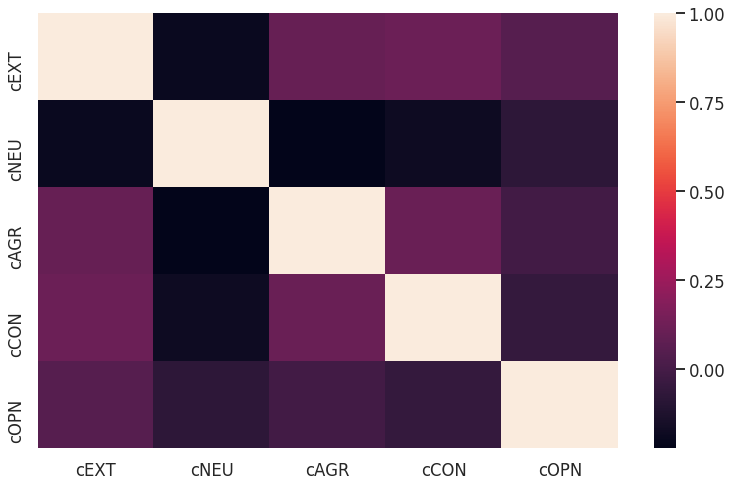

In [14]:
plt.figure(figsize=(13, 8))
sns.heatmap(df.corr());

There aren't big correlation

In [15]:
counts_classes = df[[*CLASSES]].sum()
counts_classes

cEXT    1277
cNEU    1233
cAGR    1310
cCON    1254
cOPN    1272
dtype: int64

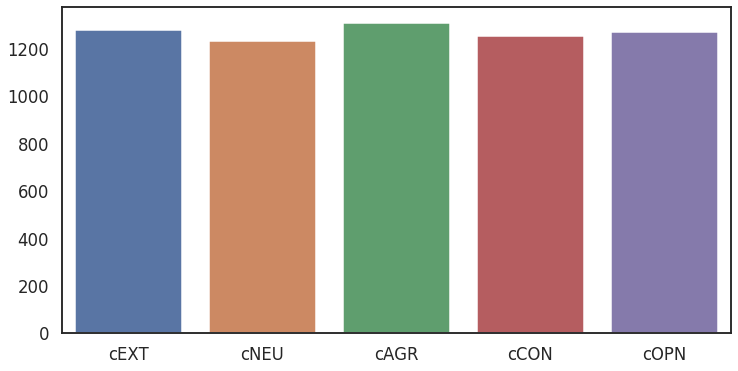

In [16]:
plt.figure(figsize=(12, 6))
sns.barplot(x=counts_classes.index, y=counts_classes.values);

Dataset is balanced.

In [0]:
X = df.TEXT.values
y = df[[*CLASSES]].values

# Text preprocessing

In [18]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
import re

def clean_str(string, TREC=False):
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s ", string)
    string = re.sub(r"\'ve", " have ", string)
    string = re.sub(r"n\'t", " not ", string)
    string = re.sub(r"\'re", " are ", string)
    string = re.sub(r"\'d" , " would ", string)
    string = re.sub(r"\'ll", " will ", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " ( ", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " \? ", string)
#    string = re.sub(r"[a-zA-Z]{4,}", "", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip() if TREC else string.strip().lower()

stop_words = set(stopwords.words('english'))

def filter_stop_words(sentences):
    arr = sentences.copy()
    for i, s in enumerate(arr):
        words = nltk.word_tokenize(s)
        s = ''
        for word in words:
            if word not in stop_words:
                s += word + ' '
        arr[i] = s
    return arr

In [0]:
X = np.vectorize(clean_str)(X)
if FILTER_STOP_WORDS:
    X = filter_stop_words(X)

In [21]:
gc.collect()

6699

In [0]:
embed_size = 300 # how big is each word vector
max_features = 31000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 850 # max number of words in essay to use
EMBEDDING_FILE = path + 'data/glove.840B.300d.txt'

In [23]:
tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n0123456789')
tokenizer.fit_on_texts(X)
list_tokenized_train = tokenizer.texts_to_sequences(X)
number_of_words_in_sentence = np.array(list(map(len, list_tokenized_train)))
X_sequence = pad_sequences(list_tokenized_train, maxlen=maxlen)
pd.DataFrame(number_of_words_in_sentence).describe()

,0
count,2408.000000
mean,665.522841
std,261.440386
min,1.000000
25%,481.750000
50%,644.000000
75%,824.000000
max,2605.000000


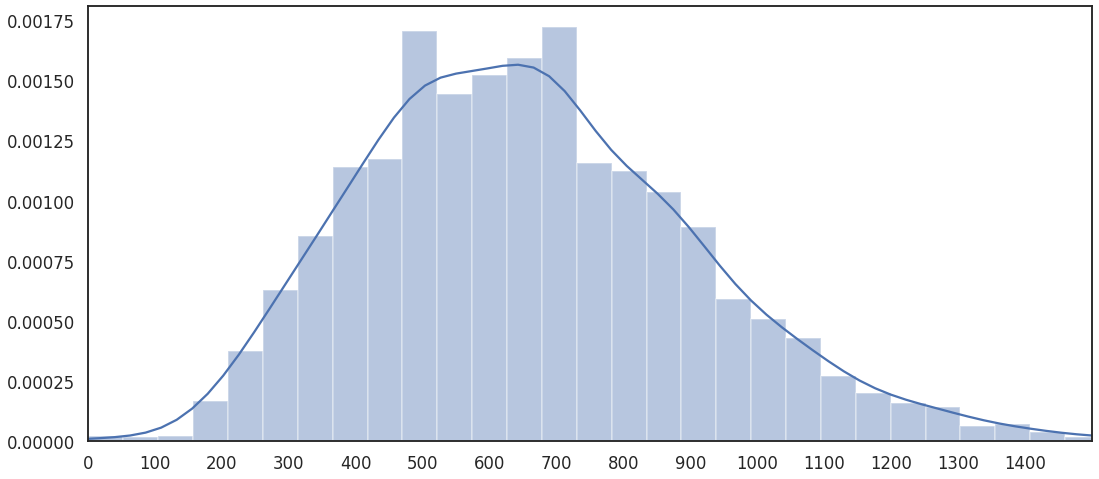

In [24]:
plt.figure(figsize=(18, 8))
ax = sns.distplot(number_of_words_in_sentence)
plt.xlim((0, 1500))
ax.set_xticks(np.arange(0, 1500, 100));

Distribution like normal

In [0]:
if FILTER_OUTLIERS_WITH_LEN_SENTENSE:
  outliers_greater = number_of_words_in_sentence > maxlen
  outliers_less = number_of_words_in_sentence < 50
  outliers = outliers_greater | outliers_less
  print(f"Outliers: {outliers.sum()}: {outliers_less.sum()} + {outliers_greater.sum()}")
  X_sequence = X_sequence[~outliers]
  y = y[~outliers]

Outliers: 133: 5 + 128


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_sequence, y, test_size=0.15, random_state=17)

In [0]:
def check_unknown_index(array, unknown, likelhood=False):
    i = array.shape[0] - 1
    count = 0
    while i >= 0 and array[i] != 0:
        if array[i] in unknown:
            count += 1
        i -= 1
    if likelhood:
        return count / float(array.shape[0] - i - 1)
    return count

def count_unknowns_in_sentences(X_sequence, likelhood=False, words=None):
    if words is None:
        woords = not_known_word
    no_known_words_in_sentences = np.zeros((X_sequence.shape[0],))
    for i, sequence in enumerate(X_sequence):
        no_known_words_in_sentences[i] = check_unknown_index(sequence, words, likelhood)
    return no_known_words_in_sentences

# Read embedding

In [0]:
model = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [0]:
emb_mean, emb_std = model.vectors.mean(), model.vectors.std()
emb_mean, emb_std

(-0.003527845, 0.13315111)

In [0]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

In [0]:
not_known_word = {}

for word, i in word_index.items():
    if i >= nb_words: continue
    embedding_index = model.vocab.get(word)
    if embedding_index is not None: 
        embedding_matrix[i] = model.vectors[embedding_index.index]
    else:
        not_known_word[i] = word

len(not_known_word)

7039

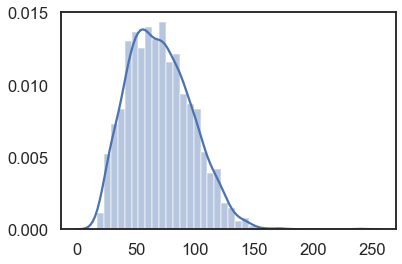

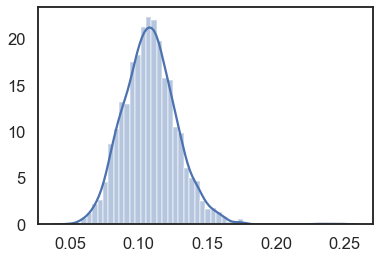

In [0]:
sns.distplot(count_unknowns_in_sentences(X_sequence))
plt.show()
sns.distplot(count_unknowns_in_sentences(X_sequence, True));

Sentences have 12% unknown words

# Try other embedding (GLOVE)

In [27]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')

embeddings_index = {}
invalid = []
for o in open(EMBEDDING_FILE, encoding='utf-8'):
    try:
        word, emb = get_coefs(*o.strip().split())
    except Exception as e:
        invalid.append(o)
    if emb is not None:
        if emb.shape[0] != embed_size:
            invalid.append(o)
        else:
            embeddings_index[word] = emb
len(invalid)

29

In [28]:
all_embs = np.stack(list(embeddings_index.values()))
emb_mean, emb_std = all_embs.mean(), all_embs.std()
emb_mean, emb_std

(-0.0058393576, 0.48782519)

In [29]:
no_known = {}

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        word = word.replace("'", "")
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            no_known[i] = word
len(no_known)

3245

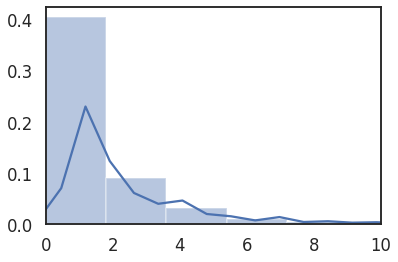

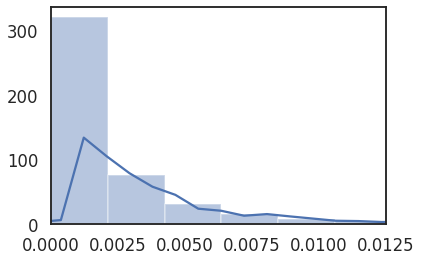

In [30]:
ax = sns.distplot(count_unknowns_in_sentences(X_sequence, words=no_known))
plt.xlim((0, 10))
plt.show();
sns.distplot(count_unknowns_in_sentences(X_sequence, True, no_known));
plt.xlim((0, 0.0125));

Model know almost all words

# Build model

In [0]:
# !pip install keras-self-attention
# from keras_self_attention import SeqSelfAttention

from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional, GlobalMaxPool1D, GRU, Flatten, concatenate
from keras.models import Model
from keras.optimizers import Adam
# %load_ext tensorboard

In [0]:
def add_axis_for_softmax(yy):
    yy = yy.reshape(-1, 1)
    temp = (yy==0).astype(np.int16)
    yy = np.append(temp, yy, axis=1)
    return yy

def merge_history(*histories):
    ext_history = {}
    for history in histories:
        if not isinstance(history, dict):
            history = history.history
        for metric in history:
            if metric in ext_history:
                ext_history[metric].extend(history[metric])
            else:
                ext_history[metric] = history[metric].copy()
    return ext_history

def draw_learning_lineplots(history, fields=None, figsize=None):
    if isinstance(history, dict):
        history = pd.DataFrame(history)
    if not figsize:
        figsize=(15, 8)
    plt.figure(figsize=figsize)
    data = history
    if fields:
        columns = []
        for field in fields:
            for col in list(history):
                if field in col:
                    columns.append(col)
        data=history[columns]
    return sns.lineplot(data=data, dashes=False)
  
def acc_for_classes(y_pred, y_true):
  y_pred = (y_pred > 0.5).astype(np.int)
  scores = []
  for i in range(y_pred.shape[1]):
    score = (y_pred[:, i] == y_true[:, i]).sum() / float(y_pred.shape[0])
    scores.append(score)
  return scores

num_model = 0

In [0]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
checkpoints = keras.callbacks.ModelCheckpoint(path + 'models/model-'+str(num_model)+'-Epoch-{epoch:02d}-Loss-{val_loss:.2f}',
                                                save_best_only=True)
# log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stopping, checkpoints]


In [157]:
inp = Input(shape=(maxlen,))
x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))(x)
# x = SeqSelfAttention(attention_activation='sigmoid')(x)
# x = concatenate(x)
# x = Flatten()(x)
x = GlobalMaxPool1D()(x)
x = Dense(5, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', # There was commented because previous version keras isn't supported
                                                                        # tf.keras.metrics.AUC(),
                                                                        # keras.metrics.Precision(),
                                                                        # keras.metrics.Recall()
                                                                    ])
model.summary()
num_model += 1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 850)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 850, 300)          8831100   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 850, 256)          439296    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 1285      
Total params: 9,271,681
Trainable params: 440,581
Non-trainable params: 8,831,100
_________________________________________________________________


In [158]:
history = model.fit(X_train, y_train, batch_size=32, epochs=5, #validation_split=0.1, 
                    validation_data=(X_test, y_test), callbacks=callbacks)

Train on 2046 samples, validate on 362 samples
Epoch 1/5
2046/2046 [==============================] - 231s 113ms/step - loss: 0.6980 - acc: 0.5155 - val_loss: 0.6969 - val_acc: 0.5182
Epoch 2/5
2046/2046 [==============================] - 225s 110ms/step - loss: 0.6858 - acc: 0.5437 - val_loss: 0.6817 - val_acc: 0.5652
Epoch 3/5
2046/2046 [==============================] - 226s 110ms/step - loss: 0.6779 - acc: 0.5675 - val_loss: 0.6918 - val_acc: 0.5287
Epoch 4/5
2046/2046 [==============================] - 224s 110ms/step - loss: 0.6674 - acc: 0.5938 - val_loss: 0.6834 - val_acc: 0.5591
Epoch 5/5
2046/2046 [==============================] - 224s 110ms/step - loss: 0.6591 - acc: 0.6102 - val_loss: 0.6762 - val_acc: 0.5823


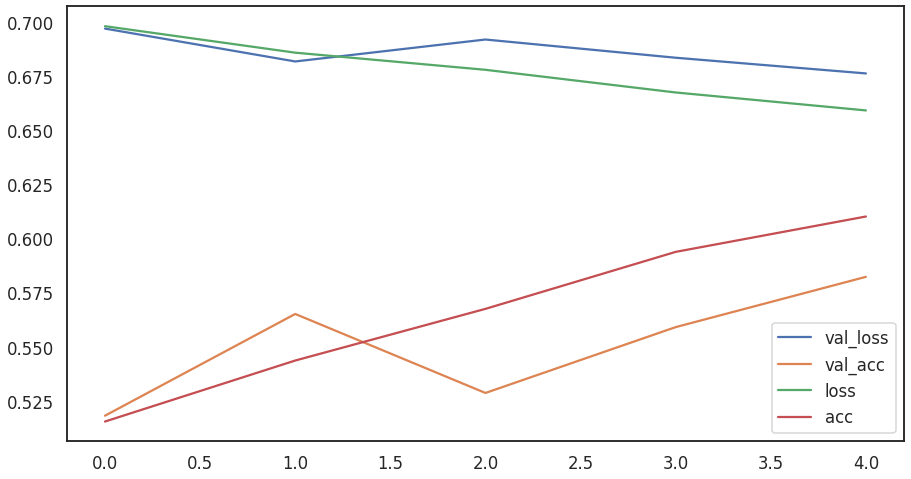

In [159]:
draw_learning_lineplots(history.history);

In [170]:
predicts = model.predict(X_train)
acc_for_classes(predicts, y_train)

[0.679863147605083,
 0.6842619745845552,
 0.6642228739002932,
 0.6622678396871945,
 0.6529814271749755]

# **Representation of model!**

In [161]:
!pip install innvestigate

In [0]:
from matplotlib import cm, transforms
from matplotlib import pyplot as plt
import innvestigate


def sequense_to_emb_seq(a):
  emb_seq = []
  for i in a:
    emb_seq.append(embedding_matrix[i])
  return np.stack(emb_seq)

# This is a utility method visualizing the relevance scores of each word to the network's prediction. 
# one might skip understanding the function, and see its output first.
def plot_text_heatmap(words, scores, title="", width=10, height=0.2, verbose=0, max_word_per_line=20):
    fig = plt.figure(figsize=(width, height))
    
    ax = plt.gca()

    ax.set_title(title, loc='left')
    tokens = words
    if verbose > 0:
        print('len words : %d | len scores : %d' % (len(words), len(scores)))

    cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
    cmap.set_clim(0, 1)
    
    canvas = ax.figure.canvas
    t = ax.transData

    # normalize scores to the followings:
    # - negative scores in [0, 0.5]
    # - positive scores in (0.5, 1]
    normalized_scores = 0.5 * scores / np.max(np.abs(scores)) + 0.5
    
    if verbose > 1:
        print('Raw score')
        print(scores)
        print('Normalized score')
        print(normalized_scores)

    # make sure the heatmap doesn't overlap with the title
    loc_y = -0.2

    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)
        
        text = ax.text(0.0, loc_y, token,
                       bbox={
                           'facecolor': color,
                           'pad': 5.0,
                           'linewidth': 1,
                           'boxstyle': 'round,pad=0.5'
                       }, transform=t)

        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        
        # create a new line if the line exceeds the length
        if (i+1) % max_word_per_line == 0:
            loc_y = loc_y -  2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width+15, units='dots')

    if verbose == 0:
        ax.axis('off')

def seq_to_words_plot(seq, scores, **kwargs):
  words = tokenizer.sequences_to_texts(seq.reshape(1, -1))[0].split()
  diff = seq.shape[0] - len(words)
  plot_text_heatmap(words, scores[diff:].reshape(-1), **kwargs)


def get_visualize_model(model, first_layer=2, last_layer=4):
  inp = Input(shape=(maxlen, embed_size))
  x = inp
  for i in range(first_layer, last_layer + 1):
    x = model.layers[i](x)
  model_for_visualize = Model(inputs=inp, outputs=x)
  model_for_visualize.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model_for_visualize

def analyze_example(analyzer, X_analyze, X_seq_ind):
  for i in range(len(CLASSES)):
    analysis = analyzer.analyze(X_analyze[np.newaxis, :], i)
    scores = analysis.sum(axis=2)
    print(f"Heatmap words of {CLASSES[i]} class.")
    seq_to_words_plot(X_seq_ind, scores[0], max_word_per_line=30)
    plt.show()

In [163]:
X_analyze_train = np.apply_along_axis(sequense_to_emb_seq, 1, X_train)
X_analyze_test = np.apply_along_axis(sequense_to_emb_seq, 1, X_test)
X_analyze_train.shape

(2046, 850, 300)

In [164]:
gc.collect()

11079

In [165]:
model_for_visualize = get_visualize_model(model)
model_for_visualize.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 850, 300)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 850, 256)          439296    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 1285      
Total params: 440,581
Trainable params: 440,581
Non-trainable params: 0
_________________________________________________________________


In [0]:
analyzer = innvestigate.create_analyzer('gradient', model_for_visualize, neuron_selection_mode="index")

## Check experiments and investigate the model

Heatmap words of cEXT class.


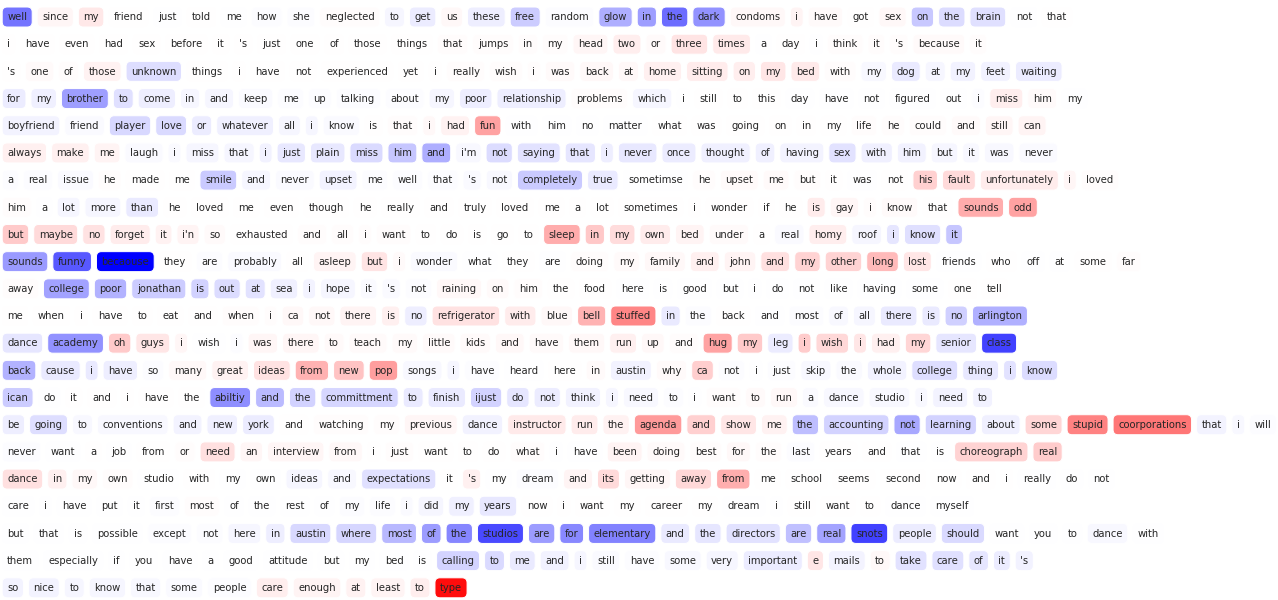

Heatmap words of cNEU class.


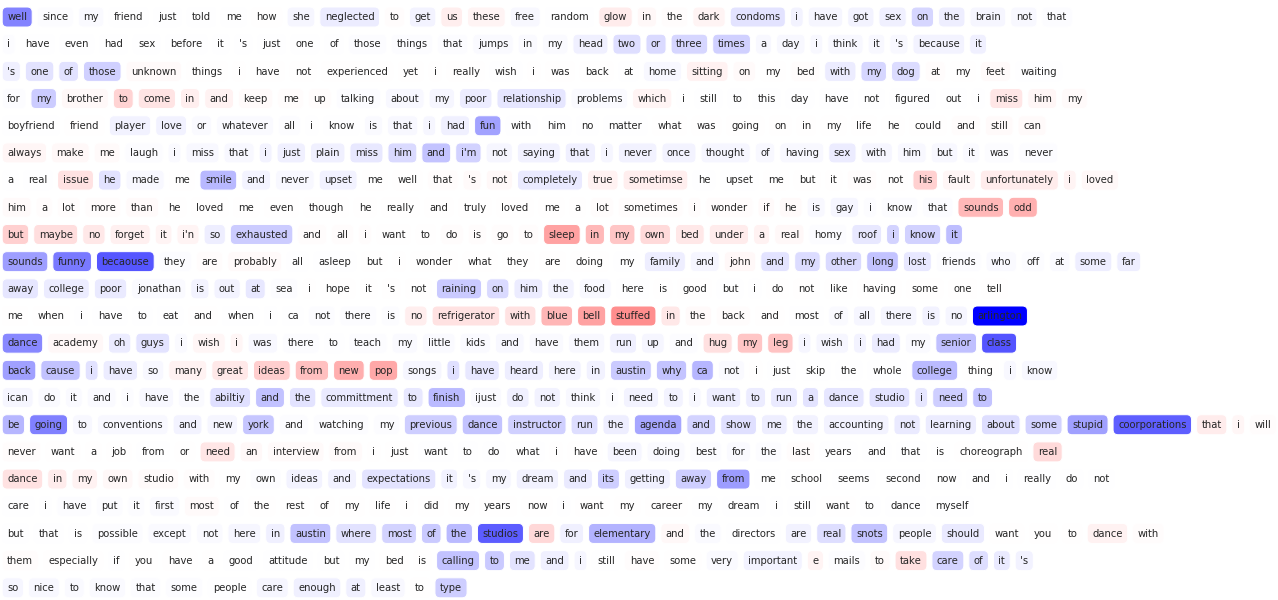

Heatmap words of cAGR class.


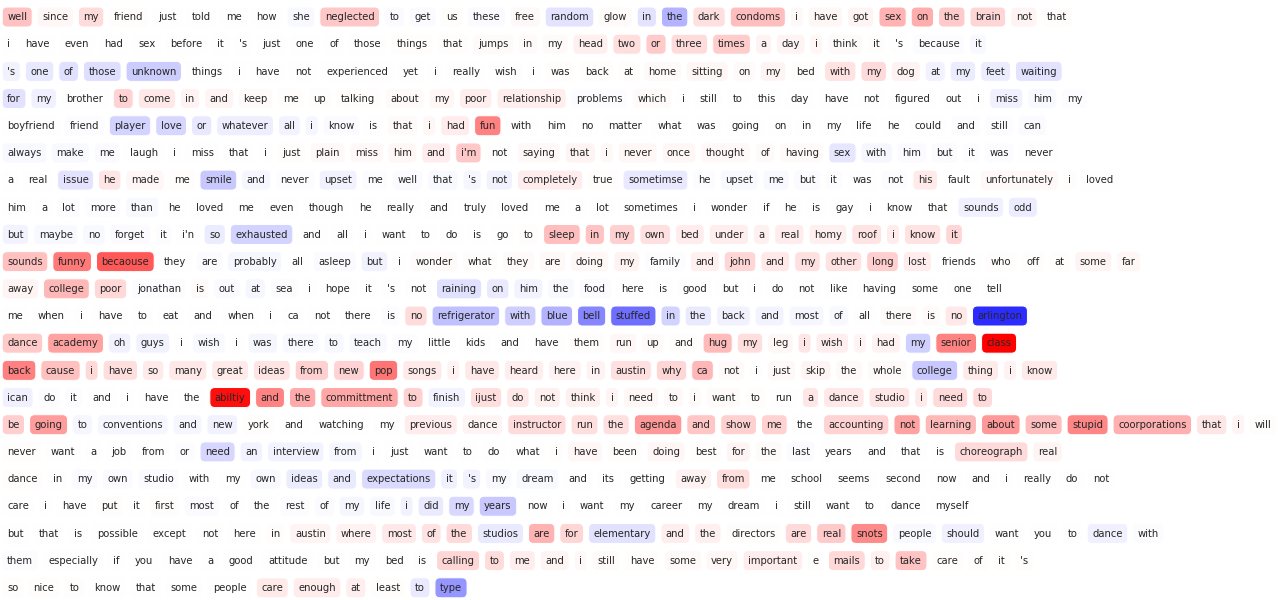

Heatmap words of cCON class.


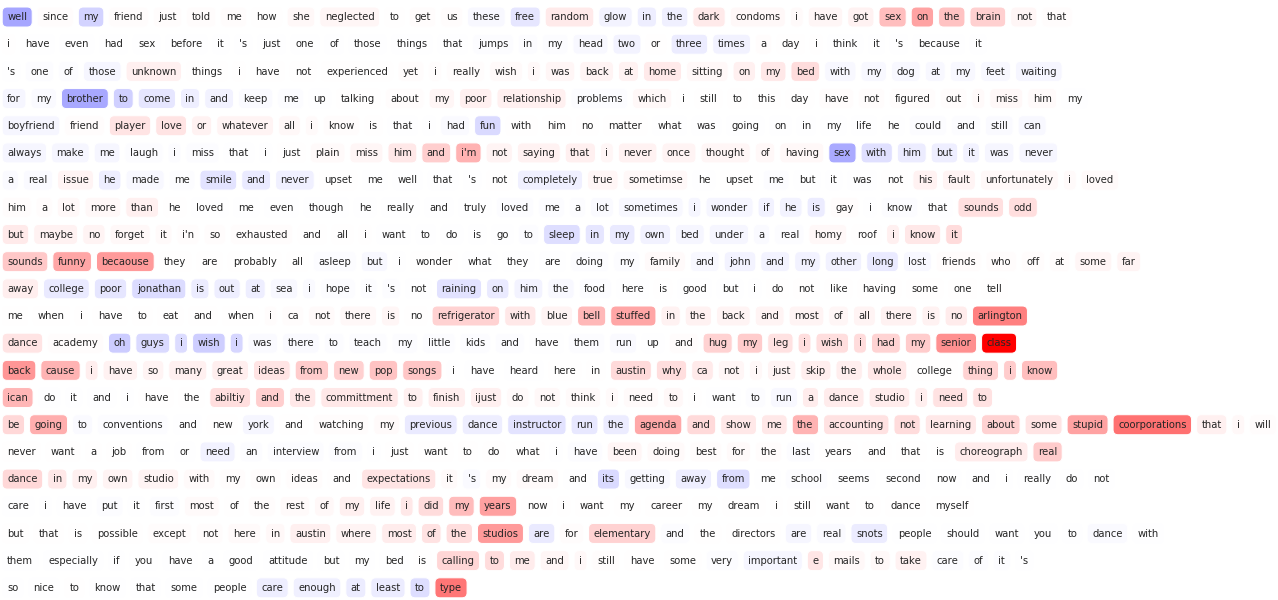

Heatmap words of cOPN class.


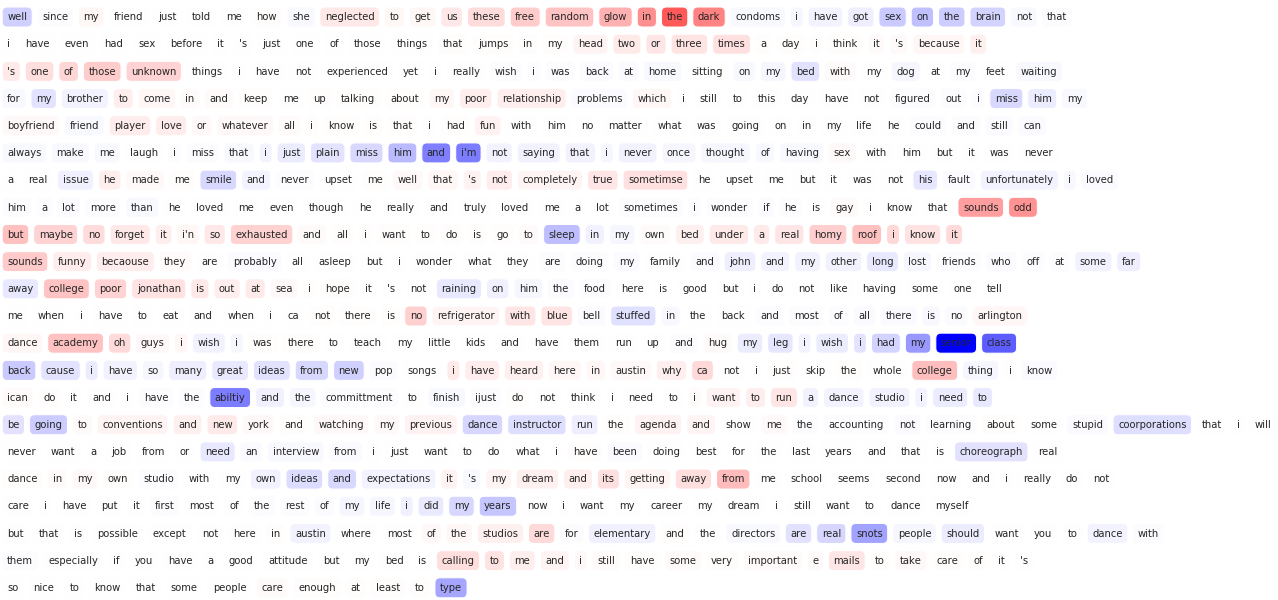

In [149]:
number_of_example = 12
analyze_example(analyzer, X_analyze_train[number_of_example],
                          X_train[number_of_example])

In [169]:
number_of_example = 5
analyze_example(analyzer, X_analyze_train[number_of_example],
                          X_train[number_of_example])

Output hidden; open in https://colab.research.google.com to view.